# Summer School on Data Science Tools and Techniques in Modelling Complex Networks

### [Bogumił Kamiński](http://bogumilkaminski.pl/about/)

## Working with graph data using Julia Language
### Day 2, Tuesday, August 20th, 2019, 13:00 to 16:00

## Random Geometric Graph

In [1]:
using Pkg
Pkg.activate(".");

In [2]:
using LightGraphs, GraphPlot, Random, PyPlot, Statistics

In [3]:
struct RandomGeometricGraph{T<:SimpleGraph}
    g::T
    r::Float64
    l::Vector{Tuple{Float64,Float64}}
end

squared distance between $(x_1, y_1)$ and $(x_2, y_2)$.

In [4]:
euclidean(x₁, y₁, x₂, y₂) = sqrt((x₁-x₂)^2 + (y₁-y₂)^2)

euclidean (generic function with 1 method)

In [5]:
function rgg_slow(n, r)
    g = SimpleGraph(n)
    l = [(rand(), rand()) for i in 1:n]
    for i in 1:n, j in i+1:n
        euclidean(l[i]..., l[j]...) < r && add_edge!(g, i, j)
    end
    RandomGeometricGraph(g, r, l)
end

rgg_slow (generic function with 1 method)

In [6]:
g = rgg_slow(200, 0.1)

RandomGeometricGraph{SimpleGraph{Int64}}({200, 588} undirected simple Int64 graph, 0.1, Tuple{Float64,Float64}[(0.771409, 0.185843), (0.82428, 0.0449005), (0.853658, 0.107051), (0.856551, 0.330597), (0.0456416, 0.483039), (0.286189, 0.543347), (0.459284, 0.161342), (0.37706, 0.24992), (0.922716, 0.498812), (0.856396, 0.989902)  …  (0.405323, 0.384544), (0.15664, 0.612892), (0.160738, 0.605905), (0.163733, 0.485492), (0.301367, 0.0811855), (0.522003, 0.328927), (0.374098, 0.920419), (0.609501, 0.345136), (0.281964, 0.431259), (0.86297, 0.65727)])

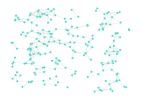

In [7]:
gplot(g.g, getindex.(g.l, 1), getindex.(g.l, 2))

In [8]:
function rgg_fast(n, r)
    g = SimpleGraph(n)
    l = [(rand(), rand()) for i in 1:n]
    k = ceil(Int, 1 / r)
    vgroups = [Int[] for i in 1:k, j in 1:k]
    for (i, loc) in enumerate(l)
        x, y = floor.(Int, loc ./ k) .+ 1
        push!(vgroups[x,y], i)
    end
    for x in 1:k, y in 1:k
        vgroup = vgroups[x, y]
        # within group links
        for a in 1:length(vgroup)
            i = vgroup[a]
            for b in i+1:1:length(vgroup)
                j = vgroup[b]
                euclidean(l[i]..., l[j]...) < r && add_edge!(g, i, j)
            end
        end
        # between group links
        if isodd(x+y)
            for (dx, dy) in ((-1, 0), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1))
                if 0 < dx < k && 0 < dy < k
                    for i in vgroup
                        for j in vgroups[x+dx, y+dy]
                            euclidean(l[i]..., l[j]...) < r && add_edge!(g, i, j)
                        end
                    end
                end
            end
        end
    end
    RandomGeometricGraph(g, r, l)
end

rgg_fast (generic function with 1 method)

In [9]:
g = rgg_fast(200, 0.1)

RandomGeometricGraph{SimpleGraph{Int64}}({200, 579} undirected simple Int64 graph, 0.1, Tuple{Float64,Float64}[(0.496994, 0.0336525), (0.696495, 0.14926), (0.780072, 0.843659), (0.876428, 0.872843), (0.0998843, 0.966791), (0.0883381, 0.663737), (0.38535, 0.584034), (0.973931, 0.095276), (0.172574, 0.295784), (0.653961, 0.770179)  …  (0.616927, 0.782718), (0.147407, 0.85734), (0.730133, 0.0335028), (0.617313, 0.515149), (0.996278, 0.935755), (0.995613, 0.440353), (0.993317, 0.336826), (0.658519, 0.861043), (0.597516, 0.945623), (0.742447, 0.916672)])

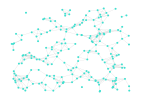

In [10]:
gplot(g.g, getindex.(g.l, 1), getindex.(g.l, 2))

In [11]:
function test_gen(nrange, rrange)
    seeds = rand(UInt64, length(nrange)*length(rrange))
    for (s, (n, r)) in zip(seeds, Iterators.product(nrange, rrange))
        Random.seed!(s)
        g1 = rgg_slow(n, r)
        Random.seed!(s)
        g2 = rgg_fast(n, r)
        @assert g1.g == g2.g && g1.l == g2.l && g1.r == g2.r
    end
    println("All OK")
end

test_gen (generic function with 1 method)

In [12]:
test_gen(rand(10:1000, 10), rand(10))

All OK


## Mean degree

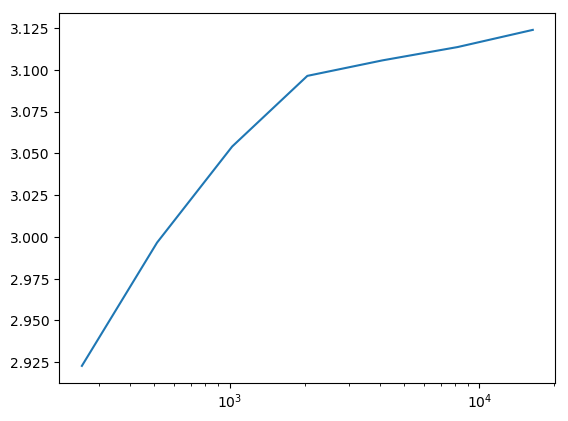

In [13]:
ns = [2^i for i in 8:14]
plot(ns, [mean(mean(degree(rgg_fast(n, 1/sqrt(n)).g)) for i in 1:16) for n in ns])
plt.xscale("log")

## Giant component

In [14]:
giant_component(n, r) =
    maximum(length.(connected_components(rgg_fast(n, r).g))) / n

giant_component (generic function with 1 method)

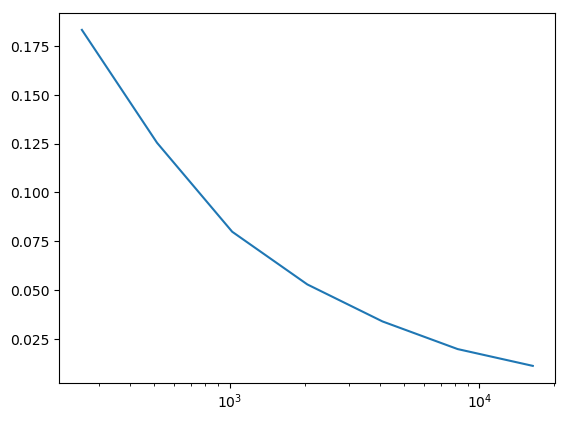

In [15]:
ns = [2^i for i in 8:14]
plot(ns, [mean(giant_component(n, 1/sqrt(n)) for i in 1:16) for n in ns])
plt.xscale("log")